# Data loading and preprocessing

## Loading Movielens-100k

This dataset comprises ratings, ranging from 1 to 5 stars, from 943 users on 1682 movies. It has been cleaned up so that each user has rated at least 20 movies. Some simple demographic information such as age, gender, genres for the users and items are also available.

In [4]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

You can get the dataset simply by following the link, other sizes are also available, for example Movielens-1M and others.

In [5]:
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
os.makedirs("../data/raw", exist_ok=True)
zip_filepath = "../data/raw/ml-100k.zip"
response = requests.get(url)
with open(zip_filepath, "wb") as zip_file:
    zip_file.write(response.content)

In [6]:
import zipfile
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall("../data/raw")

The dataset contains many useful files for machine learning , in this work we will use 3 main:
* u.data - Full dataset of 100000 ratings by 943 users on 1682 items. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of user id, item id, rating, and timestamp. The time stamps are unix seconds.
* u.item - Information about the items (movies). This is a tab separated list of movie id, movie title, release date, video release date, IMDB URL, and genres. The last 19 fields are genres and contain binary values. Movies can be of several genres at once. The movie ids are the ones used in u.data 
* u.user - Demographic information about the users. This is a tab separated list of user id, age, gender, occupation, zip code. The user ids are the ones used in u.data file. 

In [7]:
user_cols = [
    'user_id', 'age', 'sex', 
    'occupation', 'zip_code']
rating_cols = [
    'userId', 'movieId', 'rating','timestamp']

In [8]:
user_df = pd.read_csv("../data/raw/ml-100k/u.user", sep='|', 
                    names=user_cols)
user_df= user_df.drop("zip_code", axis=1)
rating_df= pd.read_csv("../data/raw/ml-100k/u.data",  sep='\t', names=rating_cols)

In [9]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100000 non-null  int64
 1   movieId    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [10]:
rating_df.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
dtypes: int64(2), object(2)
memory usage: 29.6+ KB


In [12]:
user_df.head()

,user_id,age,sex,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


Dataframes does not contain empty values, let's take a closer look at some of the aspects.

## Visualization

The first graph provides an idea of how ratings are distributed across different values, allowing you to get an idea of the frequency of each rating in the dataset.

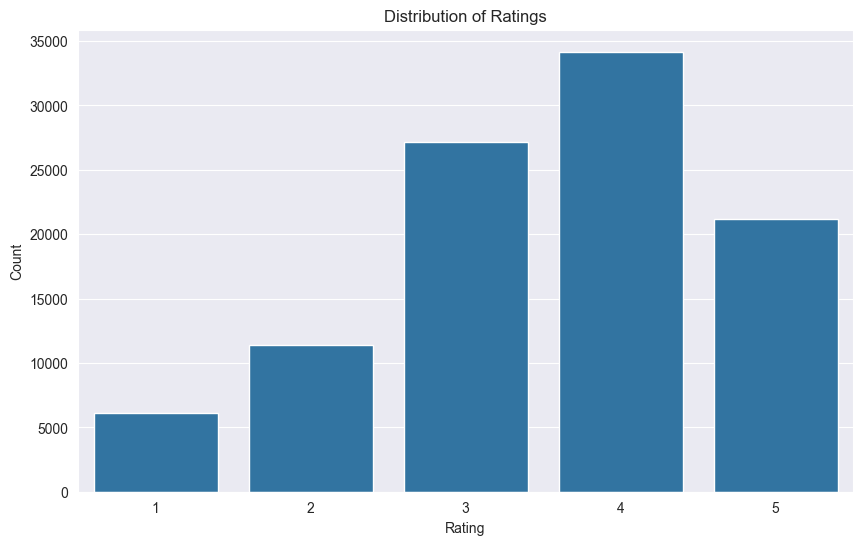

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=rating_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

We can say that the films are rated evenly most ratings are 3, 4. We will save the data for further training of models.

In [14]:
rating_df.to_csv("../data/raw/rating.csv")

The second graph, gives an idea of the distribution of users in the dataset. The presence of a kernel density estimate (KDE and) provides a smoothed curve on the histogram, giving an idea of the general trend of the distribution by age. This visualization helps to understand the age demographics of users.

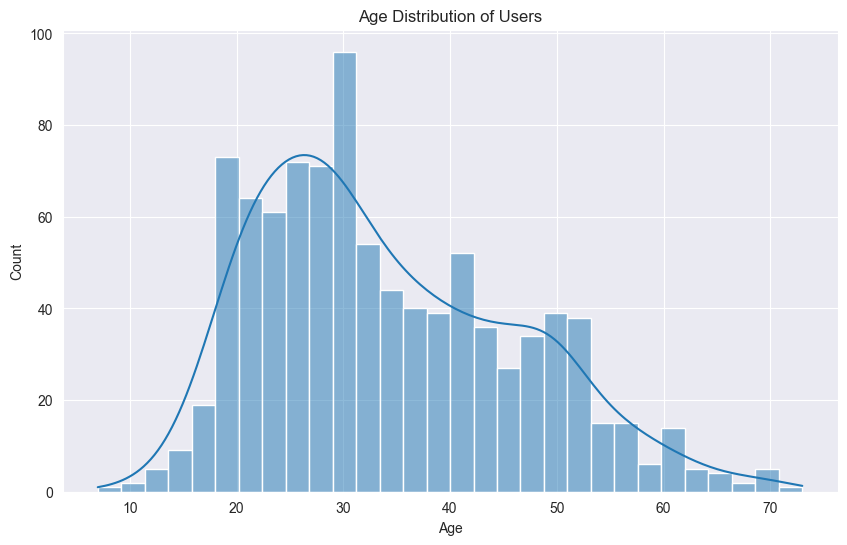

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(user_df['age'], bins=30, kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


Filter out rating_df to include only the top 20 users based on their unique user IDs. The heatmap represents the ratings given by these users to various films. The x-axis corresponds to movie views, the y-axis corresponds to user IDs, and the color intensity reflects the values of ratings. The "cold warm" color map is used to highlight differences in estimated values, and the mask is used to hide cells without estimates (filled with zeros).

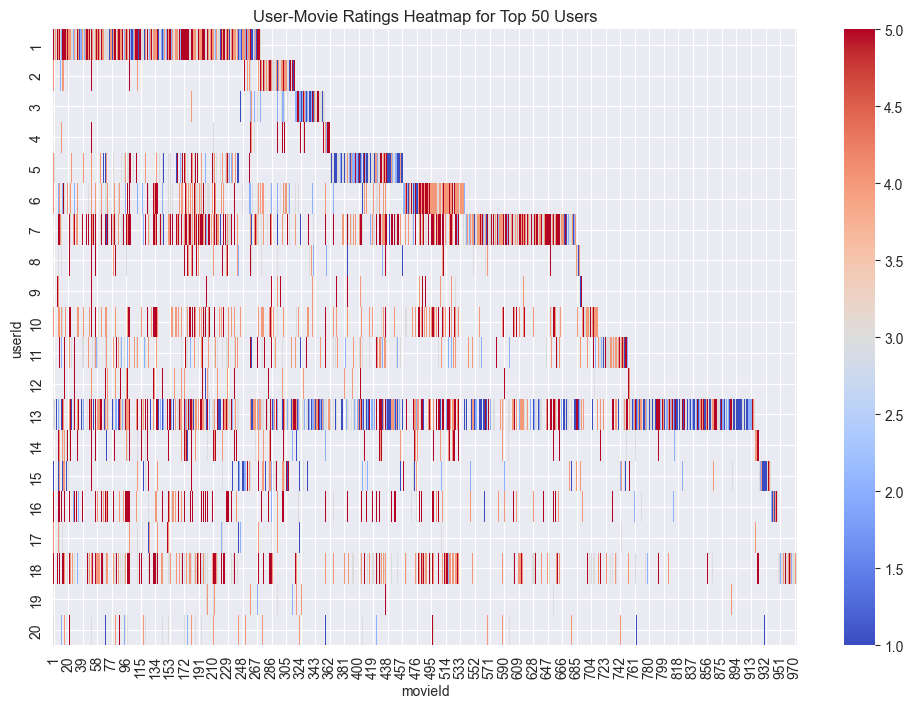

In [16]:
top_50_users = sorted(rating_df['userId'].unique())
top_50_users=top_50_users[:20]
filtered_rating_df = rating_df[rating_df['userId'].isin(top_50_users)]
plt.figure(figsize=(12, 8))
heatmap_data = filtered_rating_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
sns.heatmap(heatmap_data, cmap='coolwarm', mask=(heatmap_data == 0))
plt.title('User-Movie Ratings Heatmap for Top 50 Users')
plt.show()

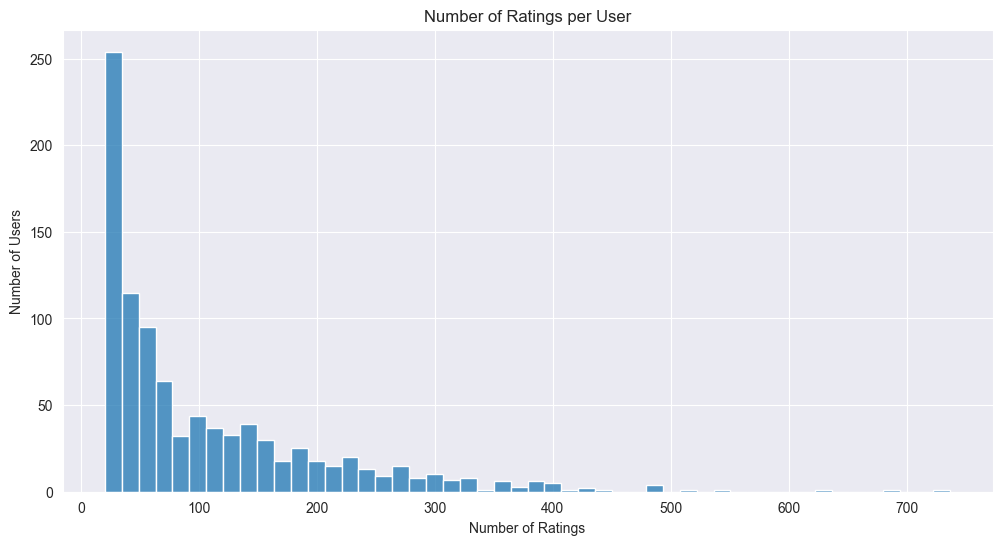

In [17]:
ratings_per_user = rating_df['userId'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(ratings_per_user, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

Based on the last two graphs, we can conclude that the dataframe is quite scattered, there are users who have rated a lot of movies and vice versa, all users have both low and high ratings.

In [18]:
user_df.to_csv("../data/raw/users.csv")

## Preprocessing users data

To use user demographic data in a machine learning model, we convert categorical features into numeric ones using LabelEncoder.

In [19]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
user_prepr = user_df
label_encoder = LabelEncoder()
user_prepr['sex'] = label_encoder.fit_transform(user_prepr['sex'])
# Occupation transformation using the average value of the target attribute (in this case, age)
profession_mapping = user_prepr.groupby('occupation')['age'].mean().to_dict()
user_prepr['occupation'] = user_prepr['occupation'].map(profession_mapping)
# Normalization of numeric features using Min-Max Scaling
scaler = MinMaxScaler()
user_prepr[['age', 'occupation']] = scaler.fit_transform(user_prepr[['age', 'occupation']])

In [20]:
user_prepr.to_csv("../data/raw/preprocessed.csv")

In [21]:
user_prepr.head()

,user_id,age,sex,occupation
0,1,0.257576,1,0.269982
1,2,0.696970,0,0.303543
2,3,0.242424,1,0.347147
3,4,0.257576,1,0.269982
4,5,0.393939,0,0.303543


## Movies visualization

In [22]:
movie_cols = ["movieId", "title", "release_date", "video_release_date", "IMDB_URL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movie_df = pd.read_csv("../data/raw/ml-100k/u.item", sep='|', names=movie_cols, encoding='latin1')


 The graph "Top Movie Genres" provides an overview of the content of the pilot episode, and the labels on the x and y axes ("Quantity" and "Genre", respectively) improve interpretability. This visualization effectively reflects the popularity of various genres of films based on their occurrence in the dataset.

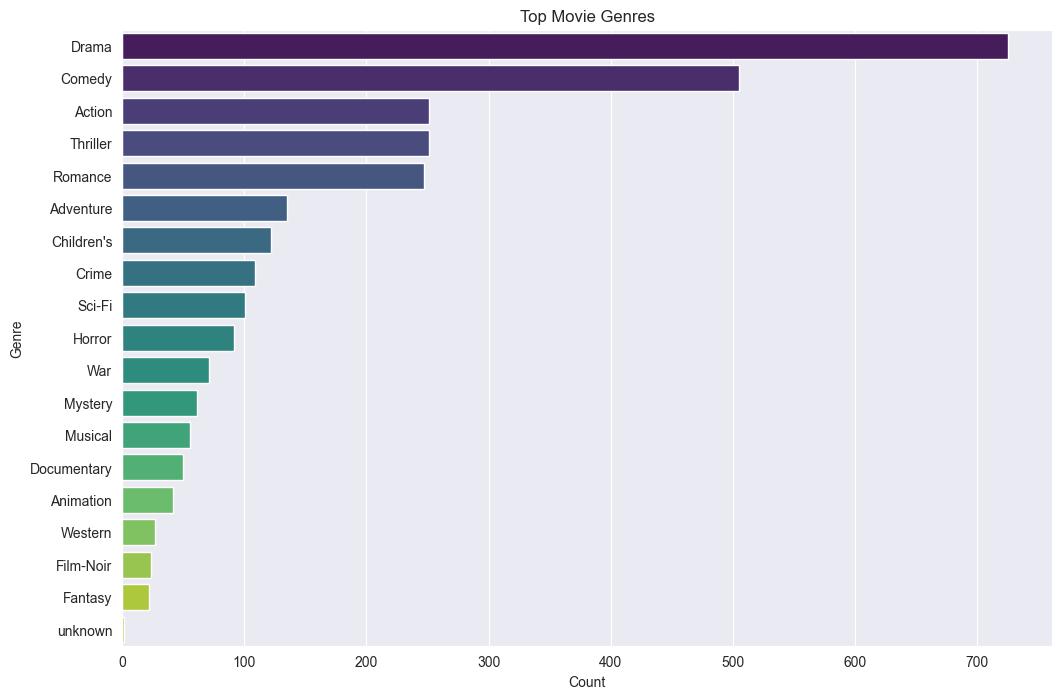

In [23]:
genres = movie_cols[5:]
genres_count = movie_df[genres].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=genres_count.values, y=genres_count.index, hue=genres_count.index, palette='viridis', legend=False)
plt.title('Top Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In the future, it is not very convenient to have a large dataset with multiple columns, we will record all genres in one column via | .

In [24]:
movie = movie_df[["movieId", "title"]].copy()

genre_columns = movie_df.columns[5:]  # Assuming genres start from the 6th column
movie["genres"] = movie_df.apply(lambda row: "|".join(genre for genre, value in zip(genre_columns, row[5:]) if value == 1), axis=1)

In [25]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,GoldenEye (1995),Action|Adventure|Thriller
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),Action|Comedy|Drama
4,5,Copycat (1995),Crime|Drama|Thriller


In [26]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  1682 non-null   int64 
 1   title    1682 non-null   object
 2   genres   1682 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.5+ KB


In [27]:
movie.to_csv("../data/raw/movies.csv")

Now all the necessary data is processed and ready for use.